In [54]:
! pip -q install pandas matplotlib
! pip install -q scikit-learn
! pip install -q joblib
! pip install -q tensorflow


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [2]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [3]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df = merge_csv(train_df_raw, train_calendar_df_raw)
test_df = merge_csv(test_df_raw, test_calendar_df_raw) 
train_df.head()

{'warehouse', 'mov_change', 'winter_school_holidays', 'shutdown', 'holiday', 'date', 'precipitation', 'frankfurt_shutdown', 'blackout', 'shops_closed', 'mini_shutdown', 'holiday_name', 'school_holidays', 'snow'}
No differences found in column: mov_change
No differences found in column: winter_school_holidays
No differences found in column: shutdown
No differences found in column: holiday
No differences found in column: precipitation
No differences found in column: frankfurt_shutdown
No differences found in column: blackout
No differences found in column: shops_closed
No differences found in column: mini_shutdown
No differences found in column: holiday_name
No differences found in column: school_holidays
No differences found in column: snow

Success. All values match across the datasets, datasets merged.
{'warehouse', 'winter_school_holidays', 'holiday', 'date', 'shops_closed', 'holiday_name', 'school_holidays'}
No differences found in column: winter_school_holidays
No differences found

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id,warehouse_limited
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05,0
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06,0
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07,0
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08,0
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09,0


### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [4]:
unavailable_features = [
    'shutdown', 'mini_shutdown', 'blackout', 'mov_change',
    'frankfurt_shutdown', 'precipitation', 'snow', 
    'user_activity_1', 'user_activity_2', 
]

In [5]:
train_df = train_df.drop(columns=unavailable_features)
train_df = train_df.drop(columns=['id']) # redundant
test_df = test_df.drop(columns=['id']) # redundant

In [6]:
# list redundant columns
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

['warehouse_limited']


In [7]:
print(train_df.head())
print(test_df.head())

  warehouse       date  orders holiday_name  holiday  shops_closed  \
0  Prague_1 2020-12-05  6895.0          NaN        0             0   
1  Prague_1 2020-12-06  6584.0          NaN        0             0   
2  Prague_1 2020-12-07  7030.0          NaN        0             0   
3  Prague_1 2020-12-08  6550.0          NaN        0             0   
4  Prague_1 2020-12-09  6910.0          NaN        0             0   

   winter_school_holidays  school_holidays  
0                       0                0  
1                       0                0  
2                       0                0  
3                       0                0  
4                       0                0  
  warehouse       date holiday_name  holiday  shops_closed  \
0  Prague_1 2024-03-16          NaN        0             0   
1  Prague_1 2024-03-17          NaN        0             0   
2  Prague_1 2024-03-18          NaN        0             0   
3  Prague_1 2024-03-19          NaN        0             0   

Add time series feature (day, monts...) here

In [8]:
#train_df = pd.concat([train_df, test_df], axis=0)

In [9]:
def process_date(df):
    df.index = df.pop('date')
    df["quarter"] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

In [10]:
process_date(train_df)
train_df.head()

,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,day_of_week,is_weekend
date,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,NaN,0,0,0,0,4,2020,12,5,340,5,1
2020-12-06,Prague_1,6584.0,NaN,0,0,0,0,4,2020,12,6,341,6,1
2020-12-07,Prague_1,7030.0,NaN,0,0,0,0,4,2020,12,7,342,0,0
2020-12-08,Prague_1,6550.0,NaN,0,0,0,0,4,2020,12,8,343,1,0
2020-12-09,Prague_1,6910.0,NaN,0,0,0,0,4,2020,12,9,344,2,0


### Plot

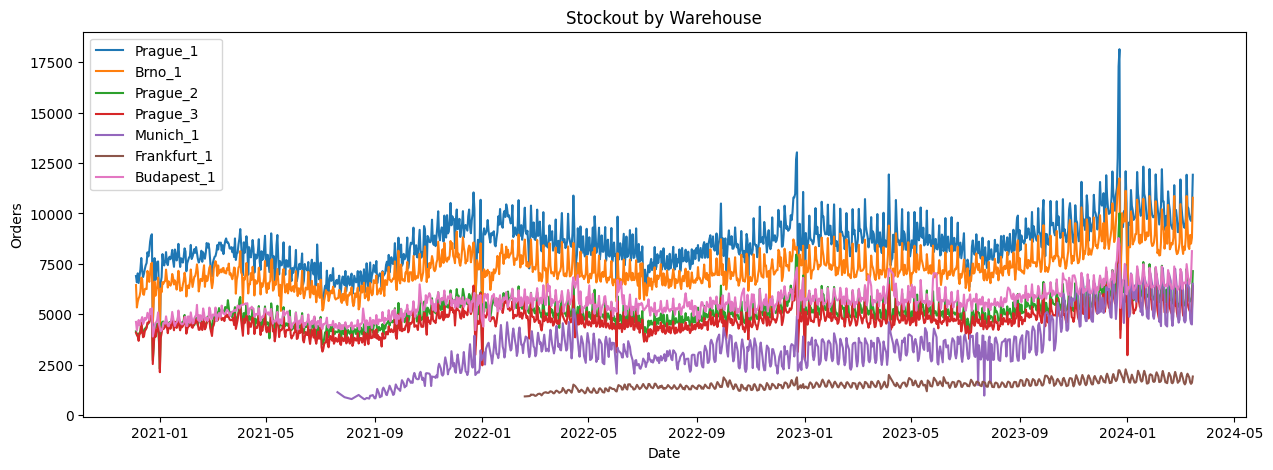

In [11]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

In [12]:
train_df['orders'].describe()

count     7340.000000
mean      5535.443869
std       2182.680279
min        790.000000
25%       4434.000000
50%       5370.000000
75%       7009.250000
max      18139.000000
Name: orders, dtype: float64

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

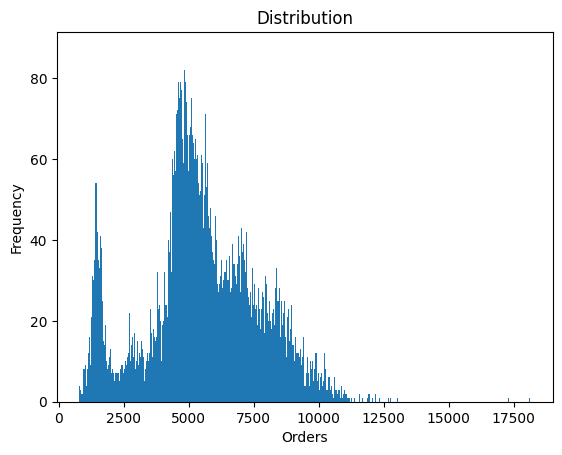

In [13]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

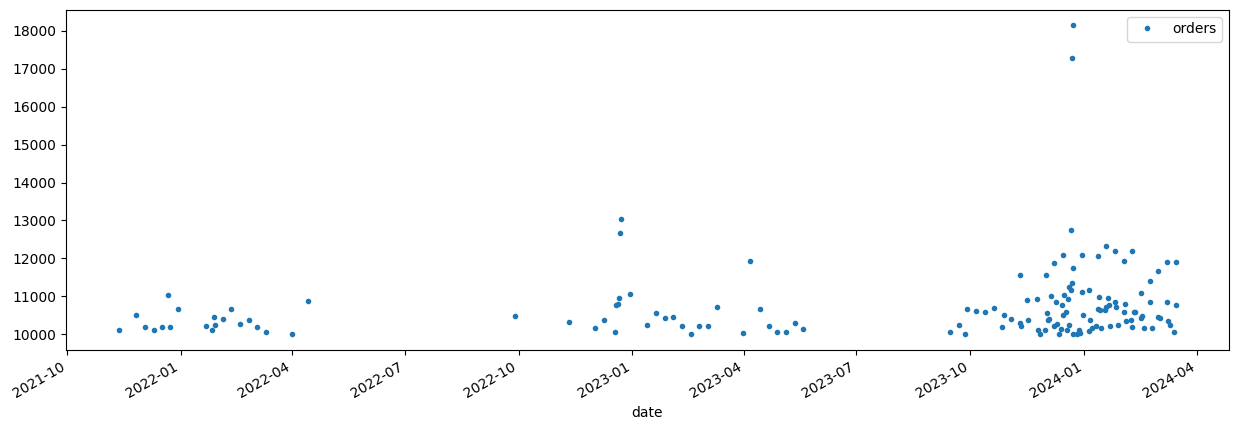

In [14]:
train_df.query('orders > 10000').plot(y='orders', figsize=(15, 5), style='.')

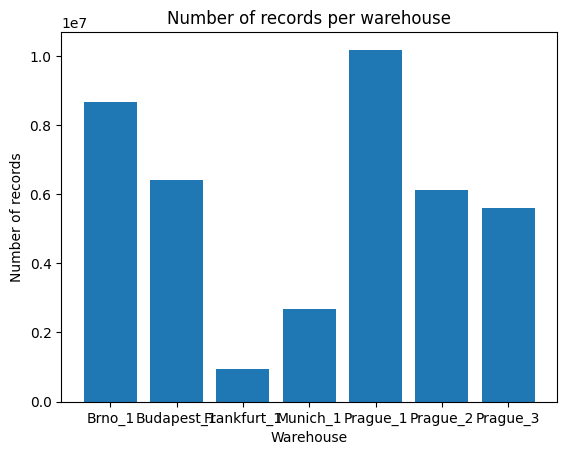

In [15]:
whs = train_df.groupby('warehouse')['orders'].sum()

plt.bar(whs.index, whs.values)
plt.xlabel('Warehouse')
plt.ylabel('Number of records')
plt.title('Number of records per warehouse')
plt.show()

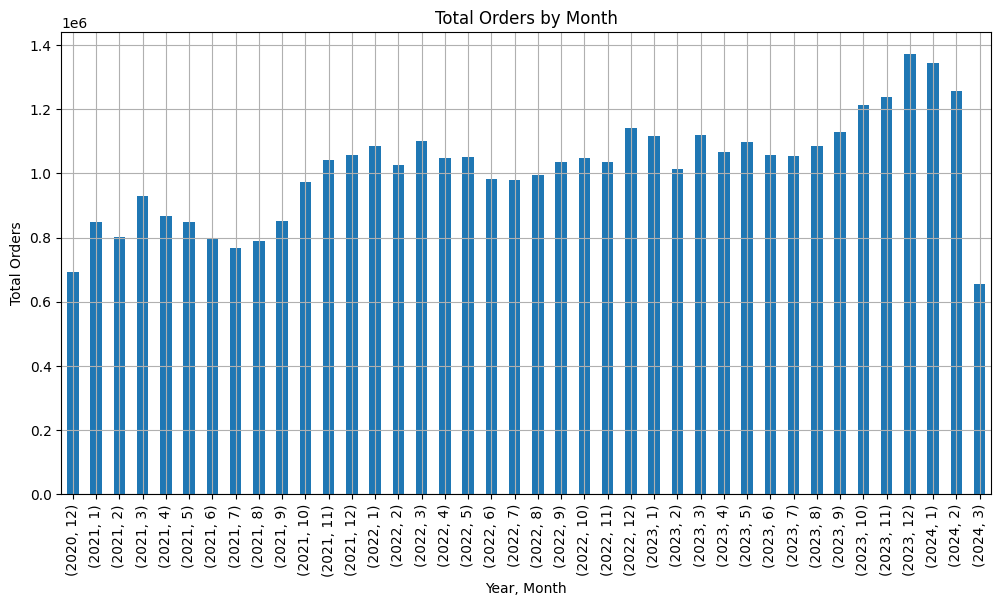

In [16]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

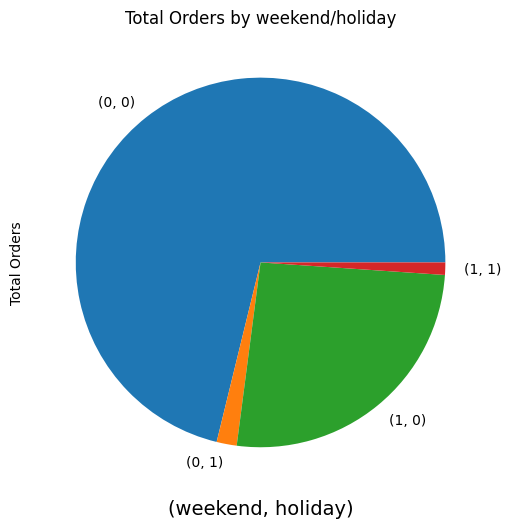

In [17]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [18]:
train_df_corr = train_df.drop(columns=['warehouse', 'holiday_name']).corr()

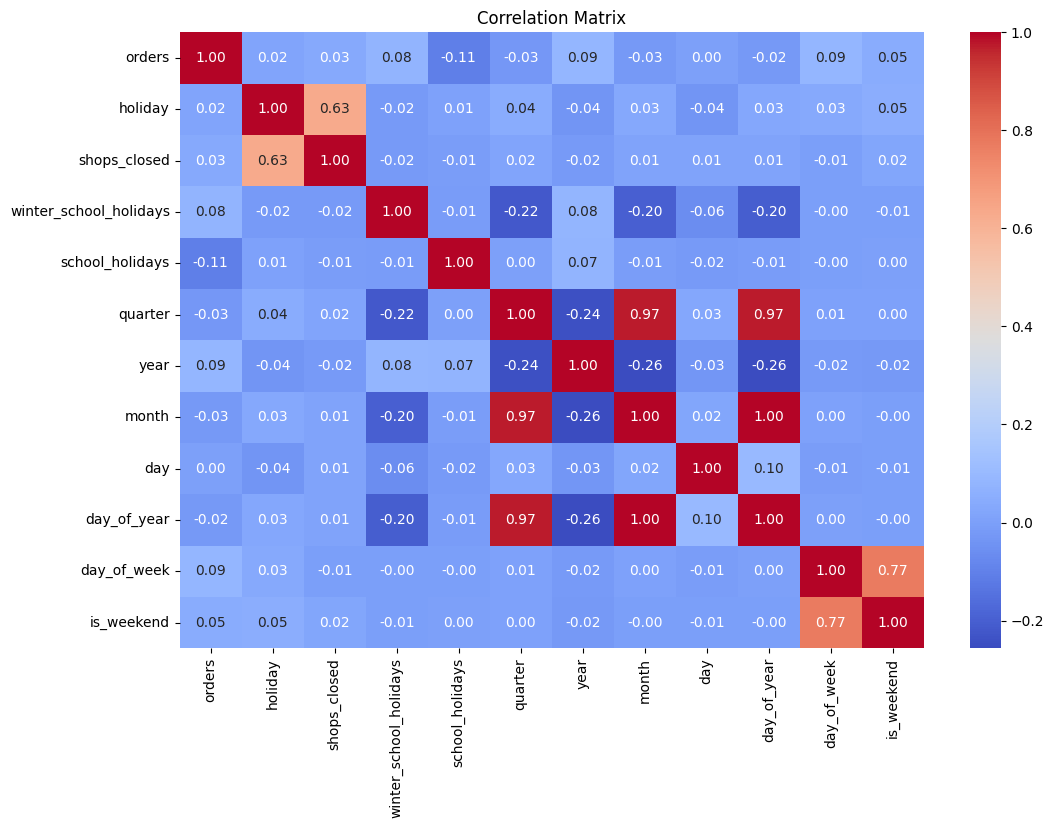

orders                    1.000000
day_of_week               0.086522
year                      0.085920
winter_school_holidays    0.077211
is_weekend                0.046594
shops_closed              0.034824
holiday                   0.018006
day                       0.002689
day_of_year              -0.024332
month                    -0.025271
quarter                  -0.029323
school_holidays          -0.105071
Name: orders, dtype: float64


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Remove Outliers

In [20]:

Q1 = train_df['orders'].quantile(0.25)
Q3 = train_df['orders'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 2.1 * IQR


iqr_outliers = train_df[(train_df['orders'] < lower_bound) | (train_df['orders'] > upper_bound)]

# Print number of outliers identified by each method
print(f"Number of IQR outliers: {iqr_outliers.shape[0]}")

iqr_outliers.head()


Number of IQR outliers: 5


,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,day_of_week,is_weekend
date,,,,,,,,,,,,,,
2022-12-22,Prague_1,12661.0,NaN,0,0,0,0,4,2022,12,22,356,3,0
2022-12-23,Prague_1,13028.0,NaN,0,0,0,0,4,2022,12,23,357,4,0
2023-12-21,Prague_1,12744.0,NaN,0,0,0,0,4,2023,12,21,355,3,0
2023-12-22,Prague_1,17282.0,NaN,0,0,0,0,4,2023,12,22,356,4,0
2023-12-23,Prague_1,18139.0,NaN,0,0,0,0,4,2023,12,23,357,5,1


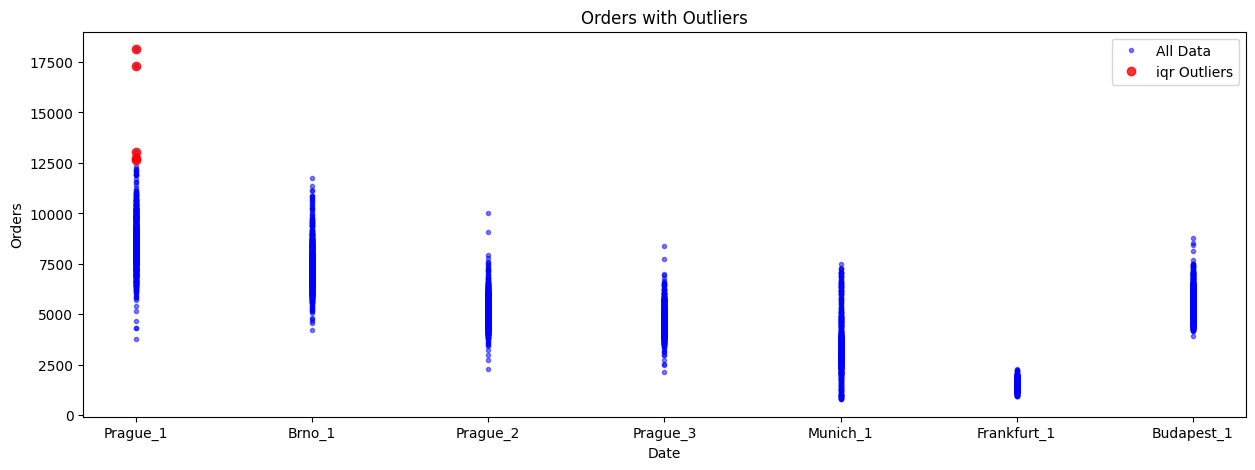

In [21]:
# Plot all data points
plt.figure(figsize=(15, 5))
plt.plot(train_df.warehouse, train_df['orders'], 'b.', alpha=0.5, label='All Data')

# Highlight outliers
plt.plot(iqr_outliers.warehouse, iqr_outliers['orders'], 'ro', alpha=0.8, label='iqr Outliers')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Orders with Outliers')
plt.legend()
plt.show()

In [22]:
# Drop outliers
train_df = train_df.drop(iqr_outliers.index)

#### Time Series Cross Validation



In [23]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=398, gap=1) # gap - 24house between train gata end - test data start
cross_val_train_df = train_df.sort_index()

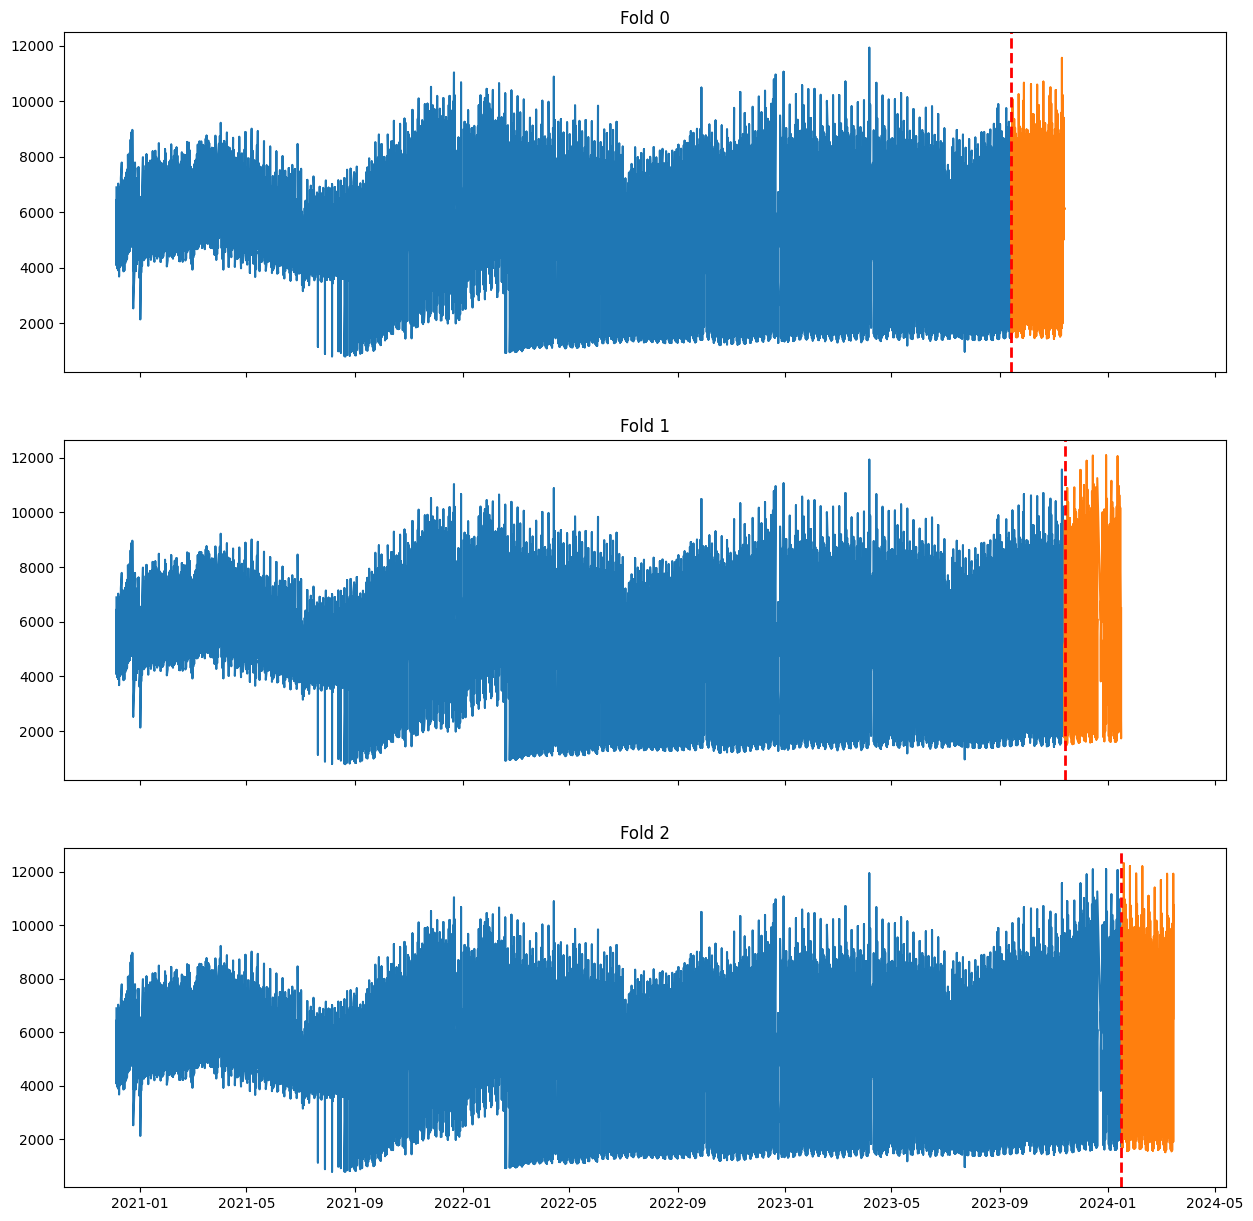

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, test_idx in tss.split(cross_val_train_df):
    train = cross_val_train_df.iloc[train_idx]
    test = cross_val_train_df.iloc[test_idx]
    
    ax[fold].plot(train.index, train['orders'], label='Train')
    ax[fold].plot(test.index, test['orders'], label='Test')
    ax[fold].set_title(f"Fold {fold}")
    ax[fold].axvline(train.index[-1], color='r', linestyle='--', lw=2)
    
    fold += 1

plt.show()

#### Forecasting Horizon

In [25]:
train_df.head()

,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,day_of_week,is_weekend
date,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,NaN,0,0,0,0,4,2020,12,5,340,5,1
2020-12-06,Prague_1,6584.0,NaN,0,0,0,0,4,2020,12,6,341,6,1
2020-12-07,Prague_1,7030.0,NaN,0,0,0,0,4,2020,12,7,342,0,0
2020-12-08,Prague_1,6550.0,NaN,0,0,0,0,4,2020,12,8,343,1,0
2020-12-09,Prague_1,6910.0,NaN,0,0,0,0,4,2020,12,9,344,2,0


### Temporal features

In [26]:
LAG_DAYS = [1, 7, 28, 98]
ROLLING_WINDOW = [7, 98]

In [27]:
# Create lag features
def create_lag_features(df, col, lag_days):
    for lag in lag_days:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Create rolling statistics
def create_rolling_features(df, col, windows):
    for window in windows:
        df[f'{col}_roll_mean_{window}'] = df[col].rolling(window=window).mean()
        df[f'{col}_roll_std_{window}'] = df[col].rolling(window=window).std()
    return df

In [29]:
train_df = create_lag_features(train_df, 'orders', LAG_DAYS)
train_df = create_rolling_features(train_df, 'orders', ROLLING_WINDOW)

train_df.tail()

,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_7,orders_lag_28,orders_lag_56,orders_roll_mean_7,orders_roll_std_7,orders_roll_mean_28,orders_roll_std_28
date,,,,,,,,,,,,,,,,,,,,,
2024-03-10,Budapest_1,6733.0,NaN,0,0,0,0,1,2024,3,10,70,6,1,6258.0,6562.0,6505.0,6776.000000,380.411181,6628.321429,376.292248
2024-03-11,Budapest_1,6492.0,NaN,0,0,0,0,1,2024,3,11,71,0,0,6450.0,6408.0,6507.0,6782.000000,374.700770,6631.321429,374.802571
2024-03-12,Budapest_1,6661.0,NaN,0,0,0,0,1,2024,3,12,72,1,0,6575.0,6392.0,6498.0,6794.285714,368.134810,6640.928571,371.877113
2024-03-13,Budapest_1,6843.0,NaN,0,0,0,0,1,2024,3,13,73,2,0,6557.0,6481.0,6616.0,6835.142857,352.969040,6653.857143,372.403377
2024-03-14,Budapest_1,8130.0,NaN,0,0,0,0,1,2024,3,14,74,3,0,6530.0,6384.0,6890.0,7063.714286,572.327329,6716.214286,461.148916


### OH encoding of categorical features

In [30]:
from sklearn.preprocessing import OneHotEncoder
import joblib

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoder on 'warehouse' and 'holiday_name' columns
encoded_features = encoder.fit_transform(train_df[['warehouse', 'holiday_name']])

# Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(['warehouse', 'holiday_name'])


# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

#print(encoded_df.head())
encoded_df = encoded_df.drop(columns=['holiday_name_nan'])
encoded_df.index = train_df.index

# Concatenate the encoded features with the original DataFrame
train_df = pd.concat([train_df, encoded_df], axis=1)

# Save the encoder
joblib.dump(encoder, 'scaler_onehot_categorical.joblib')

c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['scaler_onehot_categorical.joblib']

In [31]:
train_df.head()

,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_7,orders_lag_28,orders_lag_56,orders_roll_mean_7,orders_roll_std_7,orders_roll_mean_28,orders_roll_std_28,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,NaN,0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-06,Prague_1,6584.0,NaN,0,0,0,0,4,2020,12,6,341,6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-07,Prague_1,7030.0,NaN,0,0,0,0,4,2020,12,7,342,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-08,Prague_1,6550.0,NaN,0,0,0,0,4,2020,12,8,343,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-09,Prague_1,6910.0,NaN,0,0,0,0,4,2020,12,9,344,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Remove all categoriacl rows and remplace na values
train_df = train_df.drop(columns=['warehouse', 'holiday_name'])
train_df.fillna(0)

train_df.head()

KeyError: "['warehouse', 'holiday_name'] not found in axis"

### Min-Max scale numerical features

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Identify numerical columns to scale
numerical_cols = ['orders', 'orders_lag_7',	'orders_lag_28', 'orders_lag_56','orders_roll_mean_7','orders_roll_std_7','orders_roll_mean_28','orders_roll_std_28']
date_cols = ['year', 'month', 'day', 'day_of_week', 'quarter', 'day_of_year']

# Initialize the scaler
num_scaler = MinMaxScaler()
date_scaler = MinMaxScaler()

# Fit the scaler on the numerical columns
train_df[numerical_cols] = num_scaler.fit_transform(train_df[numerical_cols])
train_df[date_cols] = date_scaler.fit_transform(train_df[date_cols])

# Save the scaler
joblib.dump(num_scaler, 'scaler_minmax_numerical.joblib')
joblib.dump(date_scaler, 'scaler_minmax_date.joblib')

['scaler_minmax_date.joblib']

In [37]:
train_df.describe()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_7,orders_lag_28,orders_lag_56,orders_roll_mean_7,orders_roll_std_7,orders_roll_mean_28,orders_roll_std_28,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day
count,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.00000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7298.000000,7277.000000,7249.000000,7299.000000,7299.000000,7278.000000,7278.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000,7305.000000
mean,0.410534,0.027379,0.010951,0.030116,0.007118,0.483185,0.54141,0.486553,0.488195,0.484148,0.484235,0.262834,0.410406,0.410136,0.409761,0.460323,0.138418,0.477162,0.161061,0.162628,0.157290,0.085421,0.106776,0.162628,0.162628,0.162628,0.000137,0.002190,0.000137,0.003149,0.001643,0.000411,0.001643,0.001643,0.001643,0.001643,0.001643,0.001643,0.000411,0.003559,0.001643,0.001643,0.000411,0.000548,0.000411,0.000548,0.000411,0.002190,0.000274,0.000274
std,0.187732,0.163195,0.104081,0.170919,0.084076,0.383653,0.23825,0.324987,0.292467,0.299205,0.325562,0.440203,0.187771,0.187967,0.188221,0.209256,0.096991,0.220940,0.119067,0.369051,0.364098,0.279526,0.308850,0.369051,0.369051,0.369051,0.011700,0.046752,0.011700,0.056027,0.040500,0.020262,0.040500,0.040500,0.040500,0.040500,0.040500,0.040500,0.020262,0.059557,0.040500,0.040500,0.020262,0.023395,0.020262,0.023395,0.020262,0.046752,0.016545,0.016545
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.315986,0.000000,0.000000,0.000000,0.000000,0.000000,0.25000,0.181818,0.233333,0.202740,0.166667,0.000000,0.315921,0.315465,0.315205,0.358349,0.075514,0.369500,0.091191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.396392,0.000000,0.000000,0.000000,0.000000,0.333333,0.50000,0.454545,0.466667,0.482192,0.500000,0.000000,0.396088,0.395698,0.395004,0.447672,0.118399,0.462105,0.137391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [38]:
train_df.head()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_7,orders_lag_28,orders_lag_56,orders_roll_mean_7,orders_roll_std_7,orders_roll_mean_28,orders_roll_std_28,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,0.529534,0,0,0,0,1.0,0.0,1.0,0.133333,0.928767,0.833333,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-06,0.502559,0,0,0,0,1.0,0.0,1.0,0.166667,0.931507,1.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-07,0.541244,0,0,0,0,1.0,0.0,1.0,0.200000,0.934247,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-08,0.499610,0,0,0,0,1.0,0.0,1.0,0.233333,0.936986,0.166667,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-09,0.530835,0,0,0,0,1.0,0.0,1.0,0.266667,0.939726,0.333333,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create Time Series 

In [39]:
def prepare_data_for_lstm(df, target_col_index, n_timesteps):
    X, y = [], []
    for i in range(n_timesteps, len(df)):
        X.append(df.iloc[i-n_timesteps:i, :].values)
        y.append(df.iloc[i, target_col_index])
    return np.array(X), np.array(y)

# Define the number of timesteps (sequence length)
n_timesteps = 28

# Prepare training sequences
X, y = prepare_data_for_lstm(train_df, train_df.columns.get_loc('orders'), n_timesteps)

print(f"X shape: {X.shape}") 
print(f"y shape: {y.shape}") 

X shape: (7277, 28, 50)
y shape: (7277,)


### Data Loading

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [45]:
print(train_df.isna().sum())  # Check for NaNs

orders                                                                       0
holiday                                                                      0
shops_closed                                                                 0
winter_school_holidays                                                       0
school_holidays                                                              0
quarter                                                                      0
year                                                                         0
month                                                                        0
day                                                                          0
day_of_year                                                                  0
day_of_week                                                                  0
is_weekend                                                                   0
orders_lag_7                                        

### Compile and Fit the model

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_val, y_val), verbose=1)

Epoch 1/25
364/364 [==============================] - 7s 11ms/step - loss: nan - val_loss: nan
Epoch 2/25
364/364 [==============================] - 3s 9ms/step - loss: nan - val_loss: nan
Epoch 3/25
364/364 [==============================] - 3s 8ms/step - loss: nan - val_loss: nan
Epoch 4/25
364/364 [==============================] - 3s 8ms/step - loss: nan - val_loss: nan
Epoch 5/25
364/364 [==============================] - 3s 8ms/step - loss: nan - val_loss: nan
Epoch 6/25
364/364 [==============================] - 3s 8ms/step - loss: nan - val_loss: nan
Epoch 7/25
364/364 [==============================] - 3s 8ms/step - loss: nan - val_loss: nan
Epoch 8/25
364/364 [==============================] - 3s 9ms/step - loss: nan - val_loss: nan
Epoch 9/25
364/364 [==============================] - 3s 9ms/step - loss: nan - val_loss: nan
Epoch 10/25
364/364 [==============================] - 3s 9ms/step - loss: nan - val_loss: nan
Epoch 11/25
364/364 [==============================] - 3s 

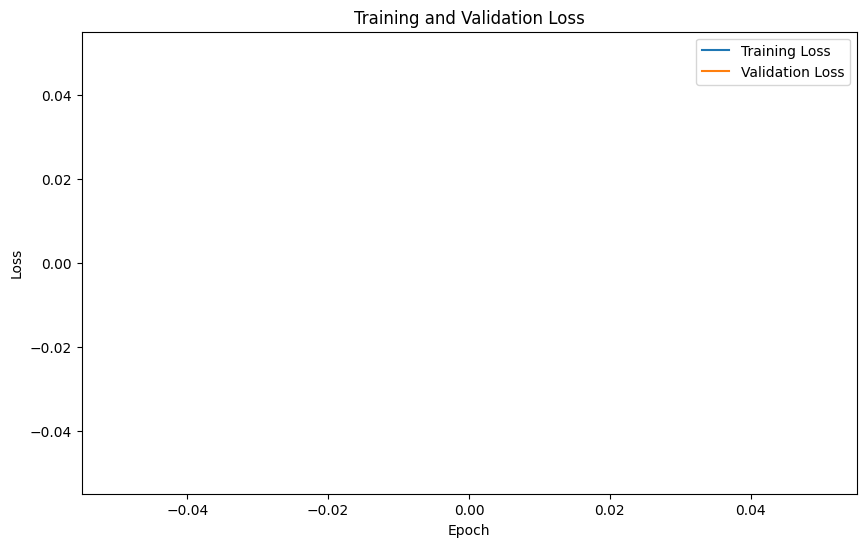

In [46]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Save the model
model.save('model_lstm.h5')

## Inference

In [48]:
import pandas as pd
import joblib

dataframe = pd.read_csv("data/test.csv")

In [49]:
loaded_oh_encoder = joblib.load('scaler_onehot_categorical.joblib')
loaded_num_scaler = joblib.load('scaler_minmax_numerical.joblib')
loaded_date_scaler = joblib.load('scaler_minmax_date.joblib')

In [51]:
from working import preprocess_data

numerical_columns = ['orders_lag_7',	'orders_lag_28', 'orders_lag_56','orders_roll_mean_7','orders_roll_std_7','orders_roll_mean_28','orders_roll_std_28']
date_columns = ['year', 'month', 'day', 'day_of_week', 'quarter', 'day_of_year']
categorical_columns = ['warehouse', 'holiday_name']



processed_data = preprocess_data(dataframe, categorical_columns, numerical_columns, date_columns, loaded_oh_encoder, loaded_num_scaler, loaded_date_scaler)

KeyError: "None of [Index(['orders_lag_7', 'orders_lag_28', 'orders_lag_56', 'orders_roll_mean_7',\n       'orders_roll_std_7', 'orders_roll_mean_28', 'orders_roll_std_28'],\n      dtype='object')] are in the [columns]"

In [74]:
processed_data = processed_data.drop(columns=['id'])
processed_data.head()     

,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,year,month,day,day_of_week,is_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-16,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.500000,0.833333,1
2024-03-17,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.533333,1.000000,1
2024-03-18,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.566667,0.000000,0
2024-03-19,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.600000,0.166667,0
2024-03-20,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.633333,0.333333,0


In [75]:
processed_data.shape

(397, 40)

In [76]:
# Compare the columns in the original and processed dataframes

X_columns = set(X.columns)
processed_data_columns = set(processed_data.columns)

if X_columns == processed_data_columns:
    print("Both dataframes have the same columns.")
else:
    print("The dataframes have different columns.")

    columns_only_in_X = X_columns - processed_data_columns
    columns_only_in_processed_data = processed_data_columns - X_columns

    if columns_only_in_X:
        print("Columns present only in X:")
        print(columns_only_in_X)

    if columns_only_in_processed_data:
        print("Columns present only in processed_data:")
        print(columns_only_in_processed_data)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [77]:
import tensorflow as tf

# Load the trained model and make predictions on processed data:
model = tf.keras.models.load_model('model_lstm.h5')
processed_data_lstm = processed_data.values.reshape((processed_data.shape[0], 1, processed_data.shape[1]))
predictions = model.predict(processed_data_lstm)

ValueError: in user code:

    File "c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 30, 12), found shape=(None, 1, 40)


In [ ]:
# Rescale the predictions to original scale:
predictions_rescaled = loaded_num_scaler.inverse_transform(predictions)
submission_df_rescaled = pd.DataFrame({'id': dataframe['id'], 'orders': predictions_rescaled.flatten()})
submission_df_rescaled.to_csv('submission_rescaled.csv', index=False)
submission_df_rescaled.head()

In [ ]:
# Add the date column as an index and warehouse column to the rescaled predictions 
submission_df_rescaled['date'] = dataframe['date']
submission_df_rescaled['warehouse'] = dataframe['warehouse']
submission_df_rescaled.head()

In [ ]:
import matplotlib.pyplot as plt
# Visualise rescaled predictions with date for every warehouse on the same plot
warehouses = submission_df_rescaled['warehouse'].unique()
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df_rescaled[submission_df_rescaled['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=wh)
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()

In [ ]:
# Visualise the predictions in compare to the same dates in the training data in year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year == 2023]
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df_rescaled[submission_df_rescaled['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=f'{wh} - Predicted')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label=f'{wh} - Actual')
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming these dataframes are already loaded
# train_df_raw: Raw training data
# submission_df_rescaled: Rescaled predictions
# warehouses: List of warehouse names

# Filter training data for the year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year == 2023]

# Create separate plots for each warehouse
for wh in warehouses:
    wh_df = submission_df_rescaled[submission_df_rescaled['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    
    plt.figure(figsize=(12, 6))
    plt.plot(wh_df['date'], wh_df['orders'], label='Predicted', linestyle='--', color='r')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label='Actual', color='b')
    plt.title(f'Predicted vs Actual Orders for {wh} in 2023')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
